In [15]:
from typing import Dict, Tuple, List, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.stats import norm
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
from gym import spaces
from gym.utils import seeding

from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise

## Utils

In [3]:
def bs_model_sim(
    S0, V0, rho, theta, sigma, kappa, r, q,
    T, n_paths, n_steps, SEED=None
):
    """
    Simulate asset price paths using exponential Brownian motion (geometric Brownian motion)
    with constant volatility instead of the Heston stochastic volatility model.
    
    Parameters
    ----------
    S0 : float
        Initial stock price
    V0 : float
        Initial variance (used as constant volatility^2)
    rho : float
        Correlation parameter (not used in this implementation)
    theta : float
        Long-term mean variance (not used in this implementation)
    sigma : float
        Volatility of variance parameter (not used in this implementation)
    kappa : float
        Rate of mean reversion parameter (not used in this implementation)
    r : float
        Risk-free interest rate
    q : float
        Dividend yield
    T : float
        Time to maturity (years)
    n_paths : int
        Number of Monte Carlo paths
    n_steps : int
        Number of time steps
    SEED : int or None
        Random seed for reproducibility
    
    Returns
    -------
    S : ndarray, shape (n_steps, n_paths)
        Simulated stock price paths following exponential Brownian motion
    v : ndarray, shape (n_steps, n_paths)
        Constant variance paths (all equal to V0)
    time : ndarray, shape (n_steps,)
        Time grid points
    """
    # time grid
    time, dt = np.linspace(0, T, n_steps, retstep=True)
    
    # set up RNG
    rng = np.random.default_rng(SEED)
    
    # constant volatility from initial variance
    vol = np.sqrt(V0)
    
    # draw all Brownian increments: shape (n_steps-1, n_paths)
    dW = rng.normal(0, np.sqrt(dt), size=(n_steps-1, n_paths))
    
    # allocate arrays
    S = np.zeros((n_steps, n_paths))
    v = np.zeros((n_steps, n_paths))
    
    # initial conditions
    S[0, :] = S0
    v[0, :] = V0  # constant variance
    
    # simulate exponential Brownian motion
    for t in range(1, n_steps):
        # exponential Brownian motion (geometric Brownian motion)
        S[t] = S[t-1] * np.exp((r - q - 0.5 * V0) * dt + vol * dW[t-1, :])
        
        # variance remains constant
        v[t, :] = V0
    
    return S, v, time

def plot_bs_paths(time, S, v, n_paths_to_plot=10, figsize=(14,6)):
    """
    Plot simulated paths for stock prices and variance.
    """
    n_steps, n_paths = S.shape
    # pick evenly spaced indices if too many
    idx = np.linspace(0, n_paths-1, n_paths_to_plot, dtype=int)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Stock price paths
    for i in idx:
        axes[0].plot(time, S[:, i], lw=1.6)
    axes[0].set_title(f"Stock Price Paths (n={n_paths_to_plot}) - Exponential Brownian Motion")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("S(t)")
    
    # Variance paths (constant)
    for i in idx:
        axes[1].plot(time, v[:, i], lw=1.6)
    axes[1].set_title(f"Variance Paths (n={n_paths_to_plot}) - Constant")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("v(t)")
    
    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_policy(model, env, option_premium, n_paths=100, render_every=None, deterministic=True):
    """
    Roll out the policy on n_paths fresh simulations and return P&L distribution.

    Args:
        model: Trained model
        env: Environment to evaluate on
        n_paths: Number of paths to evaluate
        render_every: If provided, render every n paths
        deterministic: Whether to use deterministic actions

    Returns:
        Array of P&L values
    """
    pnl_list = []
    unhedged_pnl_list = []

    for i in range(n_paths):
        obs = env.reset()
        done = False

        # Optional rendering
        if render_every and i % render_every == 0:
            env.render(mode='human')

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, info = env.step(action)

            # Optional rendering of final state
            if render_every and i % render_every == 0 and done:
                env.render(mode='human')

        # Compute terminal P&L
        S_T = env.S_path[-1]
        payoff = max(S_T - option_params['K'], 0.0)
        portfolio_value = env.position * S_T + env.cash * np.exp(env.r * env.T)
        pnl = -payoff + portfolio_value + option_premium
        pnl_list.append(pnl)

        unhedged_pnl = -payoff + option_premium  # Just the premium received minus the payoff
        unhedged_pnl_list.append(unhedged_pnl)


        # Simple progress indicator
        if (i+1) % max(1, n_paths//10) == 0:
            print(f"Progress: {i+1}/{n_paths} paths evaluated")

    return np.array(pnl_list), np.array(unhedged_pnl_list)
    

def plot_pnl_distributions(hedged_pnl, unhedged_pnl):
    """
    Plot both hedged and unhedged P&L distributions with risk metrics.
    
    Args:
        hedged_pnl: Array of P&L values with hedging
        unhedged_pnl: Array of P&L values without hedging
    """
    # Calculate statistics for hedged P&L
    mean_hedged = np.mean(hedged_pnl)
    var_95_hedged = np.percentile(hedged_pnl, 5)  # 95% VaR (5th percentile)
    cvar_95_hedged = hedged_pnl[hedged_pnl <= var_95_hedged].mean()  # CVaR
    
    # Calculate statistics for unhedged P&L
    mean_unhedged = np.mean(unhedged_pnl)
    var_95_unhedged = np.percentile(unhedged_pnl, 5)  # 95% VaR
    cvar_95_unhedged = unhedged_pnl[unhedged_pnl <= var_95_unhedged].mean()  # CVaR
    
    # Create figure with two subplots (vertically stacked)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top plot - Hedged P&L
    ax1.hist(hedged_pnl, bins=15, alpha=0.75, color='blue')
    ax1.axvline(mean_hedged, color='k', linestyle='-', linewidth=2, label='Mean')
    ax1.axvline(var_95_hedged, color='r', linestyle='--', linewidth=2, label='VaR 95%')
    ax1.axvline(cvar_95_hedged, color='m', linestyle='--', linewidth=2, label='CVaR 95%')
    ax1.legend()
    ax1.set_title('Hedged P&L Distribution (Out-of-Sample)')
    ax1.set_xlabel('P&L')
    ax1.set_ylabel('Frequency')
    
    # Add text with stats in the top plot
    hedged_stats = (f"Mean: {mean_hedged:.4f}\n"
                   f"Std: {np.std(hedged_pnl):.4f}\n"
                   f"VaR 95%: {var_95_hedged:.4f}\n"
                   f"CVaR 95%: {cvar_95_hedged:.4f}")
    ax1.text(0.02, 0.95, hedged_stats, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Bottom plot - Unhedged P&L
    ax2.hist(unhedged_pnl, bins=15, alpha=0.75, color='red')
    ax2.axvline(mean_unhedged, color='k', linestyle='-', linewidth=2, label='Mean')
    ax2.axvline(var_95_unhedged, color='r', linestyle='--', linewidth=2, label='VaR 95%')
    ax2.axvline(cvar_95_unhedged, color='m', linestyle='--', linewidth=2, label='CVaR 95%')
    # ax2.legend()
    ax2.set_title('Unhedged P&L Distribution (Out-of-Sample)')
    ax2.set_xlabel('P&L')
    ax2.set_ylabel('Frequency')
    
    # Add text with stats in the bottom plot
    unhedged_stats = (f"Mean: {mean_unhedged:.4f}\n"
                     f"Std: {np.std(unhedged_pnl):.4f}\n"
                     f"VaR 95%: {var_95_unhedged:.4f}\n"
                     f"CVaR 95%: {cvar_95_unhedged:.4f}")
    ax2.text(0.02, 0.95, unhedged_stats, transform=ax2.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print(f"Risk Reduction from Hedging:")
    print(f"VaR Improvement: {var_95_unhedged - var_95_hedged:.4f}")
    print(f"CVaR Improvement: {cvar_95_unhedged - cvar_95_hedged:.4f}")
    print(f"Std Dev Reduction: {np.std(unhedged_pnl) - np.std(hedged_pnl):.4f}")

### Simulator check

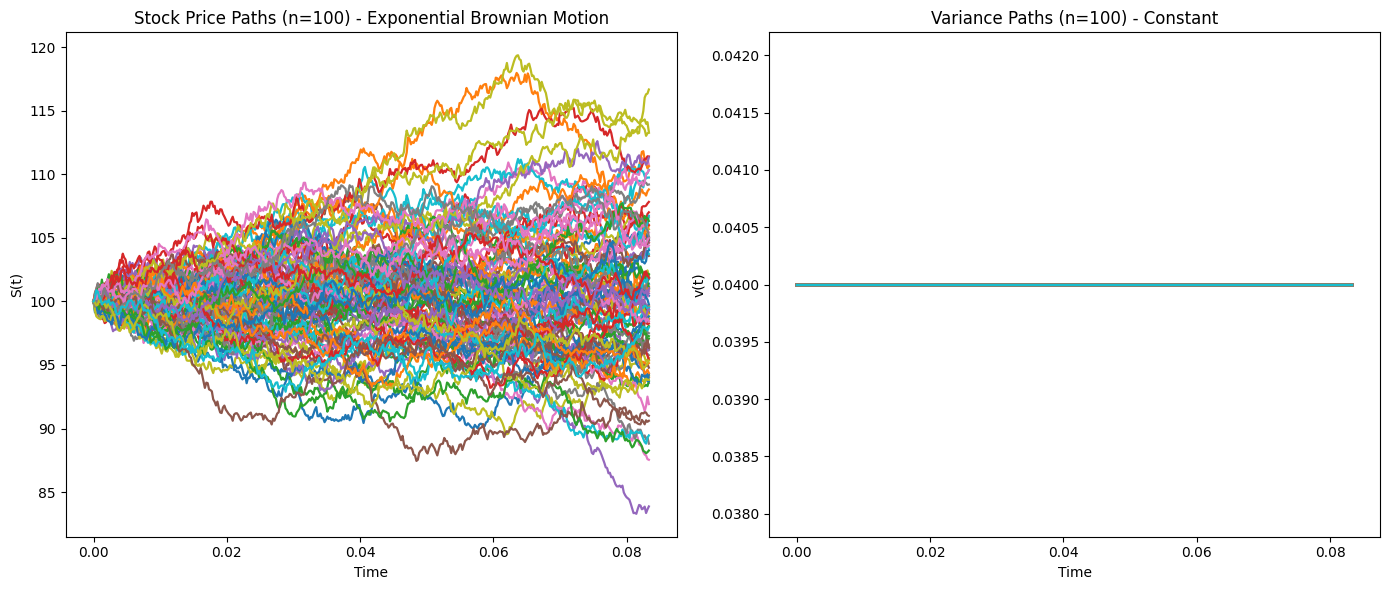

In [5]:
# Parameters
S0 = 100.0      # Initial stock price
V0 = 0.04       # Initial variance (constant volatility^2 = 20%^2)
rho = -0.7      # Not used in exponential Brownian motion
theta = 0.04    # Not used in exponential Brownian motion
sigma = 0.3     # Not used in exponential Brownian motion
kappa = 2.0     # Not used in exponential Brownian motion
r = 0.05        # Risk-free rate
q = 0.0         # Dividend yield
T = 1/12        # Time to maturity
n_paths = 1000  # Number of paths
n_steps = 400   # Number of time steps

# Simulate paths
S, v, time = bs_model_sim(S0, V0, rho, theta, sigma, kappa, r, q, T, n_paths, n_steps, SEED=42)

# Plot results
plot_bs_paths(time, S, v, n_paths_to_plot=100)

### Sanity Check

In [6]:
# sanity check for simulation is ok 

def call_option(S_paths, K, r=0.0, T=1/12):
    # take the terminal prices (last column)
    ST = S_paths[-1]
    # payoff per path
    payoffs = np.maximum(ST - K, 0.0)
    # average and discount back to today
    return np.exp(-r * T) * np.mean(payoffs)

# simulate
S, v, time = bs_model_sim(
    S0=100, V0=0.04, rho=-0.7, theta=0.04, sigma=0.28, kappa=1.0,
    r=0.00, q=0.00, T=1/12, n_paths=100000, n_steps=400, SEED=None
)

price = call_option(S, K=100, r=0.00, T=1/12)
print(f"Call option price ≃ {price:.4f}")

Call option price ≃ 2.2983


## Environment

In [10]:
class BSMHedgingEnv_Daily(gym.Env):
    """
    OpenAI Gym environment for hedging a European call using underlying simulated by Heston model.
    Modified to allow only daily rebalancing while maintaining a self-financing portfolio.

    Observation: [S_t, V_t, time_to_maturity, current_position, pnl, moneyness]
    Action: continuous hedge ratio (number of shares to hold)
    Reward: -proportional transaction cost at each step; at terminal step includes penalty on hedging error.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 heston_params: dict,
                 option_params: dict,
                 cost_rate: float = 0.001,
                 n_steps: int = 1000,
                 rebalance_frequency: int = 1,  # Default is daily (1)
                 action_lower: float = 0.0,
                 action_upper: float = 0.8,
                 lambda_: float = 1,
                 r_sig: float = 1,
                 r_const: float = 5,
                 reward_type: str = 'squared_error',
                 scaling_factors: Optional[Dict[str, float]] = None,
                 seed: Optional[int] = None):
        super().__init__()
        # Heston parameters
        self.S0 = heston_params['S0']
        self.V0 = heston_params['V0']
        self.rho = heston_params['rho']
        self.theta = heston_params['theta']
        self.sigma = heston_params['sigma']
        self.kappa = heston_params['kappa']
        self.r = heston_params['r']
        self.q = heston_params.get('q', 0.0)
        self.T = option_params['T']

        # Option parameters
        self.K = option_params['K']
        self.r = option_params['r']

        self.cost_rate = cost_rate
        self.n_steps = n_steps
        self.reward_type = reward_type
        self.scaling_factors = scaling_factors or self._default_scaling_factors()
        self.lambda_ = lambda_ 
        self.r_sig = r_sig      # Controls the width of the "acceptable" range around zero
        self.r_const = r_const

        # Daily rebalancing parameters
        self.rebalance_frequency = rebalance_frequency
        self.action_lower = action_lower
        self.action_upper = action_upper
        # Calculate steps per day based on total steps and time horizon
        self.steps_per_day = int(n_steps / (self.T * 252))  # Assuming 252 trading days per year
        self.trading_days = min(int(self.T * 252), n_steps // self.steps_per_day)

        # Create a list of indices where rebalancing is allowed
        self.rebalance_indices = [i * self.steps_per_day for i in range(self.trading_days + 1)]

        # Action space: continuous hedge ratio 
        # Negative values represent short positions in the stock
        self.action_space = spaces.Box(low=self.action_lower, high=self.action_upper, shape=(1,), dtype=np.float32)

        # Observation space: [normalized S_t, normalized V_t, normalized time_to_maturity,
        # normalized position, normalized pnl, moneyness]
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0], dtype=np.float32),
            high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

        self.seed_value = seed
        if seed is not None:
            self.seed(seed)

        self.S_path = None
        self.V_path = None
        self.times = None
        self.current_step = 0
        self.position = 0.0
        self.cash = 0.0
        self.portfolio_values = []
        self.cum_pnl = 0.0
        self.next_rebalance_step = 0
        self.can_rebalance = True

        # Tracking variables for analysis
        self.history = {
            'actions': [],
            'positions': [],
            'rewards': [],
            'stock_prices': [],
            'variances': [],
            'cash_balance': [],
            'costs': [],
            'portfolio_values': [],
            'pnl': [],
            'rebalance_days': []  # Track which days rebalancing occurred
        }

        # Initialize environment
        self.reset()

    def _default_scaling_factors(self) -> Dict[str, float]:
        """
        Define default scaling factors for observation normalization.

        Returns
        -------
        dict
            Dictionary with default scaling factors
        """
        return {
            'price': self.S0,          # Normalize price by initial price
            'variance': self.V0,       # Normalize variance by initial variance
            'time': self.T,            # Normalize time by total time to maturity
            'position': 1.0,           # No scaling for position by default
            'pnl': self.S0            # Scale PnL by initial price
        }

    def _normalize_observation(self, obs: np.ndarray) -> np.ndarray:
        """
        Normalize the observation vector for better learning.

        Parameters
        ----------
        obs : ndarray
            Raw observation vector [S_t, V_t, tau, position, pnl, moneyness]

        Returns
        -------
        ndarray
            Normalized observation vector
        """
        normalized = np.array([
            (obs[0] / self.scaling_factors['price']) - 1.0,      # Center price around 0
            (obs[1] / self.scaling_factors['variance']) - 1.0,   # Center variance around 0
            obs[2] / self.scaling_factors['time'],               # Time to maturity [0, 1]
            obs[3] / self.scaling_factors['position'],           # Position
            obs[4] / self.scaling_factors['pnl'],                # PnL
            obs[5]                                               # Moneyness indicator
        ], dtype=np.float32)

        return normalized

    def _generate_path(self):
        # Generate a single path for one episode
        # Note: sim_heston_ct86 function is imported from outside this class
        self.S_path, self.V_path, self.times = bs_model_sim(
            self.S0, self.V0, self.rho, self.theta,
            self.sigma, self.kappa, self.r,
            self.q, self.T, n_paths=1,
            n_steps=self.n_steps, SEED=self.seed_value)

        self.S_path = self.S_path.flatten()
        self.V_path = self.V_path.flatten()

    def _calculate_portfolio_value(self):
        """Calculate the current value of the hedging portfolio"""
        t = self.current_step
        S_t = self.S_path[t]

        # Time to maturity
        tau = self.T - self.times[t]

        # Value of stock position + cash (with interest)
        port_val = self.position * S_t + self.cash * np.exp(self.r * tau)

        # Option payoff at current price and time (for European call)
        # This represents the liability we're hedging against
        option_value = self._estimate_option_value(S_t, self.V_path[t], tau)

        # PnL is option value minus portfolio value (positive is good)
        pnl = -option_value + port_val

        return port_val, pnl

    def _estimate_option_value(self, S_t, V_t, tau):
        """
        Estimate the option value at the current time
        For simplicity, using a rough approximation for a call option
        In reality, you'd use a more sophisticated Heston option pricing model
        """
        if tau <= 0.0001:  # At maturity
            return max(S_t - self.K, 0.0)

        # Simple approximation based on the Black-Scholes formula components
        # Adjusted for volatility (using sqrt of variance from Heston)
        moneyness = S_t / self.K
        vol_term = np.sqrt(V_t) * np.sqrt(tau)
        time_decay = np.exp(-self.r * tau)

        # Rough option price approximation
        if S_t > self.K:
            # In the money
            intrinsic = S_t - self.K * time_decay
            time_value = 0.4 * S_t * vol_term
            return intrinsic + time_value
        else:
            # Out of the money
            return 0.4 * S_t * vol_term * moneyness

    def seed(self, seed: Optional[int] = None) -> List[int]:
        """
        Set the random seed for this environment.

        Parameters
        ----------
        seed : int, optional
            Random seed

        Returns
        -------
        list
            List containing the seed
        """
        self.seed_value = seed
        if seed is not None:
            np.random.seed(seed)
        return [seed]

    def reset(self):
        self._generate_path()
        self.current_step = 0
        self.position = 0.0  # initial hedge position
        self.cash = 0.0      # cash account, accumulates proceeds and costs
        self.cum_pnl = 0.0   # cumulative PnL
        self.next_rebalance_step = 0
        self.can_rebalance = True

        # Reset history
        self.history = {
            'actions': [],
            'positions': [],
            'rewards': [],
            'stock_prices': [],
            'variances': [],
            'cash_balance': [],
            'costs': [],
            'portfolio_values': [],
            'pnl': [],
            'rebalance_days': []
        }

        # Calculate initial portfolio value and PnL
        port_val, pnl = self._calculate_portfolio_value()
        self.history['portfolio_values'].append(port_val)
        self.history['pnl'].append(pnl)
        self.portfolio_values = [port_val]

        return self._get_obs()

    def step(self, action: np.ndarray):
        """
        Takes a step in the environment using the specified action.

        Parameters
        ----------
        action : ndarray
            Action vector [hedge_ratio]

        Returns
        -------
        ndarray
            Next observation
        float
            Reward for the action
        bool
            Whether the episode is done
        dict
            Additional information about the environment
        """
        t = self.current_step
        S_t = self.S_path[t]
        V_t = self.V_path[t]
        tau = self.T - self.times[t]

        # Check if rebalancing is allowed at this step
        is_rebalancing_day = t in self.rebalance_indices

        # Calculate portfolio value before rebalancing
        port_val_before, pnl_before = self._calculate_portfolio_value()

        # Apply rebalancing action only on rebalancing days
        if is_rebalancing_day:
            # clip/format action to ensure it's within bounds
            h_new = float(np.clip(action[0], self.action_space.low[0], self.action_space.high[0]))

            # compute transaction cost for rebalancing
            trade_size = h_new - self.position
            cost = self.cost_rate * abs(trade_size) * S_t

            # update cash: pay for trade and cost (self-financing constraint)
            self.cash -= trade_size * S_t + cost
            self.position = h_new

            # Record rebalancing day
            self.history['rebalance_days'].append(t)
        else:
            # No rebalancing on non-rebalancing days
            h_new = self.position
            cost = 0.0

        # Calculate portfolio value and PnL after rebalancing
        port_val, pnl = self._calculate_portfolio_value()
        self.cum_pnl = pnl

        # Record state for history
        self.history['actions'].append(h_new)
        self.history['positions'].append(self.position)
        self.history['stock_prices'].append(S_t)
        self.history['variances'].append(V_t)
        self.history['cash_balance'].append(self.cash)
        self.history['costs'].append(cost)
        self.history['portfolio_values'].append(port_val)
        self.history['pnl'].append(pnl)
        self.portfolio_values.append(port_val)

        # move to next step
        self.current_step += 1
        done = (self.current_step == self.n_steps)

        # Calculate reward
        if is_rebalancing_day:
            # On rebalancing days, penalize for transaction costs
            reward = -cost

            if self.reward_type in ('immediate_pnl', 'zero_target_gaussian'):
                # Reward based on change in PnL minus cost
                if len(self.history['pnl']) >= 2:
                    pnl_change = self.history['pnl'][-1] - self.history['pnl'][-2]
                    reward += pnl_change
        else:
            # On non-rebalancing days, keep reward at 0
            reward = 0.0
        
        # At terminal step, add hedging error penalty
        if done:
            S_T = self.S_path[-1]
            payoff = max(S_T - self.K, 0.0)
            final_port_val = self.position * S_T + self.cash * np.exp(self.r * self.T)
            final_pnl = -payoff + final_port_val

            if self.reward_type == 'mean_variance':
                # Mean-variance reward (negative exponential utility)
                reward += -(1 / self.lambda_) * np.exp(-self.lambda_ * final_pnl)
            elif self.reward_type == 'pnl':
                # Direct PnL reward
                reward += final_pnl
            elif self.reward_type == 'squared_error':
                # Negative squared error reward
                reward += -final_pnl**2
            elif self.reward_type == 'immediate_pnl':
                # Already included intermediate PnL changes
                reward += 10 * final_pnl  # Emphasize final outcome
            elif self.reward_type == 'zero_target_gaussian':
                reward += self.r_const * np.exp(-(final_pnl**2)/(2*self.r_sig**2))  # Peaks at 1.0 when PnL=0
            else:
                # Default to squared error
                reward = -final_pnl**2

            info = {
                'final_stock_price': S_T,
                'option_payoff': payoff,
                'portfolio_value': final_port_val,
                'hedging_error': final_pnl,
                'total_cost': sum(self.history['costs']),
                'final_position': self.position,
                'final_cash': self.cash,
                'total_rebalances': len(self.history['rebalance_days'])
            }
        else:
            info = {
                'current_pnl': pnl,
                'last_cost': cost,
                'is_rebalancing_day': is_rebalancing_day,
            }

        # Record reward
        self.history['rewards'].append(reward)

        obs = self._get_obs()
        return obs, reward, done, info

    def _get_obs(self):
        """
        Get the current observation vector

        Returns
        ------
        ndarray
            Normalized observation vector [norm_S_t, norm_V_t, norm_tau, norm_position, norm_pnl, moneyness]
        """
        t = self.current_step
        if t >= len(self.times):
            t = len(self.times) - 1

        S_t = self.S_path[t]
        V_t = self.V_path[t]
        tau = self.T - self.times[t]

        # Calculate moneyness indicator: -1 for out-of-the-money, 1 for in-the-money
        moneyness = 1.0 if S_t > self.K else -1.0

        # Add PnL to observation
        raw_obs = np.array([S_t, V_t, tau, self.position, self.cum_pnl, moneyness], dtype=np.float32)

        return self._normalize_observation(raw_obs)

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        """
        Render the current state of the environment.

        Parameters
        ----------
        mode : str, optional
            Rendering mode, options are 'human' and 'rgb_array'

        Returns
        -------
        ndarray, optional
            RGB array if mode is 'rgb_array', None otherwise
        """
        if mode == 'human':
            t = self.current_step
            t = min(t, len(self.times) - 1)
            S_t = self.S_path[t]
            is_rebalancing_day = t in self.rebalance_indices

            print(f"Step {t}/{self.n_steps}:")
            print(f"  Stock Price: {self.S_path[t]:.4f}")
            print(f"  Variance: {self.V_path[t]:.6f}")
            print(f"  Time to Maturity: {self.T - self.times[t]:.4f}")
            print(f"  Current Position: {self.position:.4f}")
            print(f"  Cash Balance: {self.cash:.4f}")
            print(f"  Rebalancing Day: {is_rebalancing_day}")

            if t > 0:
                print(f"  Transaction Cost: {self.history['costs'][-1]:.4f}")
                print(f"  Reward: {self.history['rewards'][-1]:.4f}")
                print(f"  Current PnL: {self.history['pnl'][-1]:.4f}")
                print(f"  Moneyness (S/K): {S_t/self.K:.4f}")
                
                if S_t < self.K:
                    print("  Option Status: Out-of-the-money")
                else:
                    print("  Option Status: In-the-money")


            # If at terminal step, print additional information
            if t == (self.n_steps - 1):
                S_T = self.S_path[-1]
                option_payoff = max(S_T - self.K, 0.0)
                port_val = self.position * S_T + self.cash * np.exp(self.r * self.T)
                print(f"Terminal State:")
                print(f"  Final Stock Price: {S_T:.4f}")
                print(f"  Option Payoff: {option_payoff:.4f}")
                print(f"  Portfolio Value: {port_val:.4f}")
                print(f"  Hedging Error: {port_val - option_payoff:.4f}")
                print(f"  Total Cost: {sum(self.history['costs']):.4f}")
                print(f"  Total Rebalances: {len(self.history['rebalance_days'])}")

            return None

        elif mode == 'rgb_array':
            # Create visualization and return as RGB array
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))

            # Plot stock price path
            axes[0, 0].plot(self.times[:self.current_step+1], self.S_path[:self.current_step+1])
            axes[0, 0].set_title('Stock Price Path')
            axes[0, 0].set_xlabel('Time')
            axes[0, 0].set_ylabel('Price')

            # Plot variance path
            axes[0, 1].plot(self.times[:self.current_step+1], self.V_path[:self.current_step+1])
            axes[0, 1].set_title('Variance Path')
            axes[0, 1].set_xlabel('Time')
            axes[0, 1].set_ylabel('Variance')

            # Plot position history
            if self.current_step > 0:
                time_points = self.times[:self.current_step]
                axes[1, 0].plot(time_points, self.history['positions'][:self.current_step])
                axes[1, 0].set_title('Hedge Position')
                axes[1, 0].set_xlabel('Time')
                axes[1, 0].set_ylabel('Position')

                # Mark rebalancing days with vertical lines
                rebalance_times = [self.times[idx] for idx in self.history['rebalance_days'] if idx < self.current_step]
                for rt in rebalance_times:
                    axes[1, 0].axvline(x=rt, color='r', linestyle='--', alpha=0.3)

                # Plot portfolio value history
                if len(self.portfolio_values) > 1:
                    axes[1, 1].plot(time_points, self.portfolio_values[:self.current_step])
                    axes[1, 1].set_title('Portfolio Value')
                    axes[1, 1].set_xlabel('Time')
                    axes[1, 1].set_ylabel('Value')

            plt.tight_layout()

            # Convert plot to RGB array
            fig.canvas.draw()
            # Get the RGBA buffer from the figure
            w, h = fig.canvas.get_width_height()
            buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            # Reshape it to a proper image and convert to RGB
            buf = buf.reshape((h, w, 4))
            # Convert RGBA to RGB
            img = buf[:, :, :3]
            plt.close(fig)

            return img

        else:
            raise ValueError(f"Unsupported render mode: {mode}")

    def close(self):
        """Clean up resources."""
        plt.close('all')

    def get_history(self) -> Dict[str, List]:
        """
        Get the history of the environment for analysis.

        Returns
        -------
        dict
            Dictionary containing the history of actions, positions, rewards, etc.
        """
        return self.history

## TD3 1 sigma [3, 4, 5, 7, 9] const

In [9]:
from stable_baselines3 import TD3

this itteration the r_sig = 1, and r_const = 3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 89.5085
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -0.6636
  Rebalancing Day: True
  Transaction Cost: 0.0223
  Reward: 2.4583
  Current PnL: -0.6626
  Moneyness (S/K): 0.8951
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 89.5085
  Option Payoff: 0.0000
  Portfolio Value: -0.6626
  Hedging Error: -0.6626
  Total Cost: 0.2691
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.9649
  Variance: 0.040000

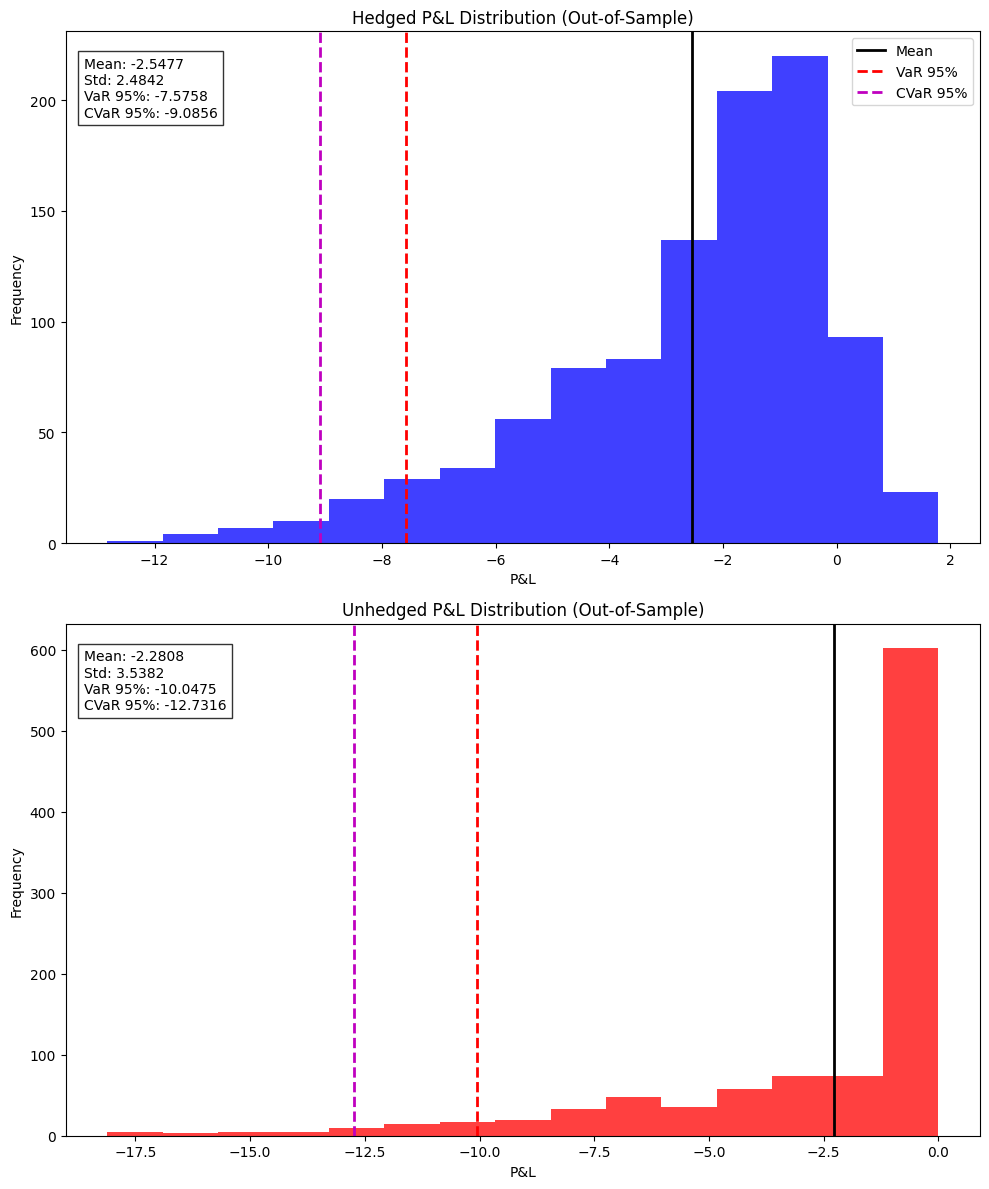

Risk Reduction from Hedging:
VaR Improvement: -2.4717
CVaR Improvement: -3.6461
Std Dev Reduction: 1.0540
---------------------------
this itteration the r_sig = 1, and r_const = 4
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.1489
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.8918
  Current PnL: -1.9511
  Moneyness (S/K): 0.9815
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.1489
  Option Payoff: 0.0000
  Portfolio Value: -1.9511
  Hedging Error: -1.9511
  Total Cost: 0.1000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0

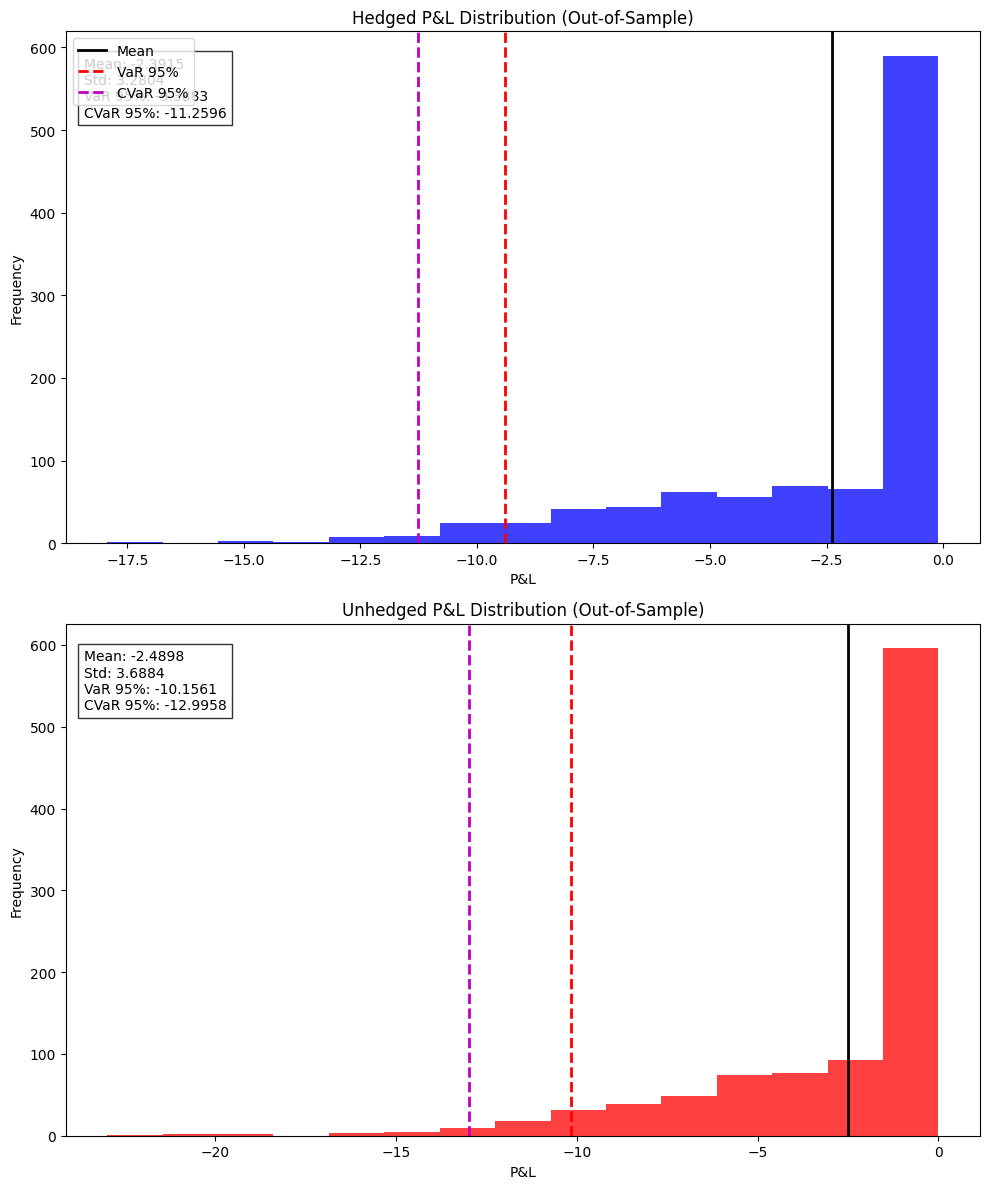

Risk Reduction from Hedging:
VaR Improvement: -0.7678
CVaR Improvement: -1.7362
Std Dev Reduction: 0.4080
---------------------------
this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 101.4155
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.9881
  Cash Balance: -100.4037
  Rebalancing Day: True
  Transaction Cost: 0.0922
  Reward: 1.5280
  Current PnL: -1.6102
  Moneyness (S/K): 1.0142
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 101.4155
  Option Payoff: 1.4155
  Portfolio Value: -0.1947
  Hedging Error: -1.6102
  Total Cost: 0.4299
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.000

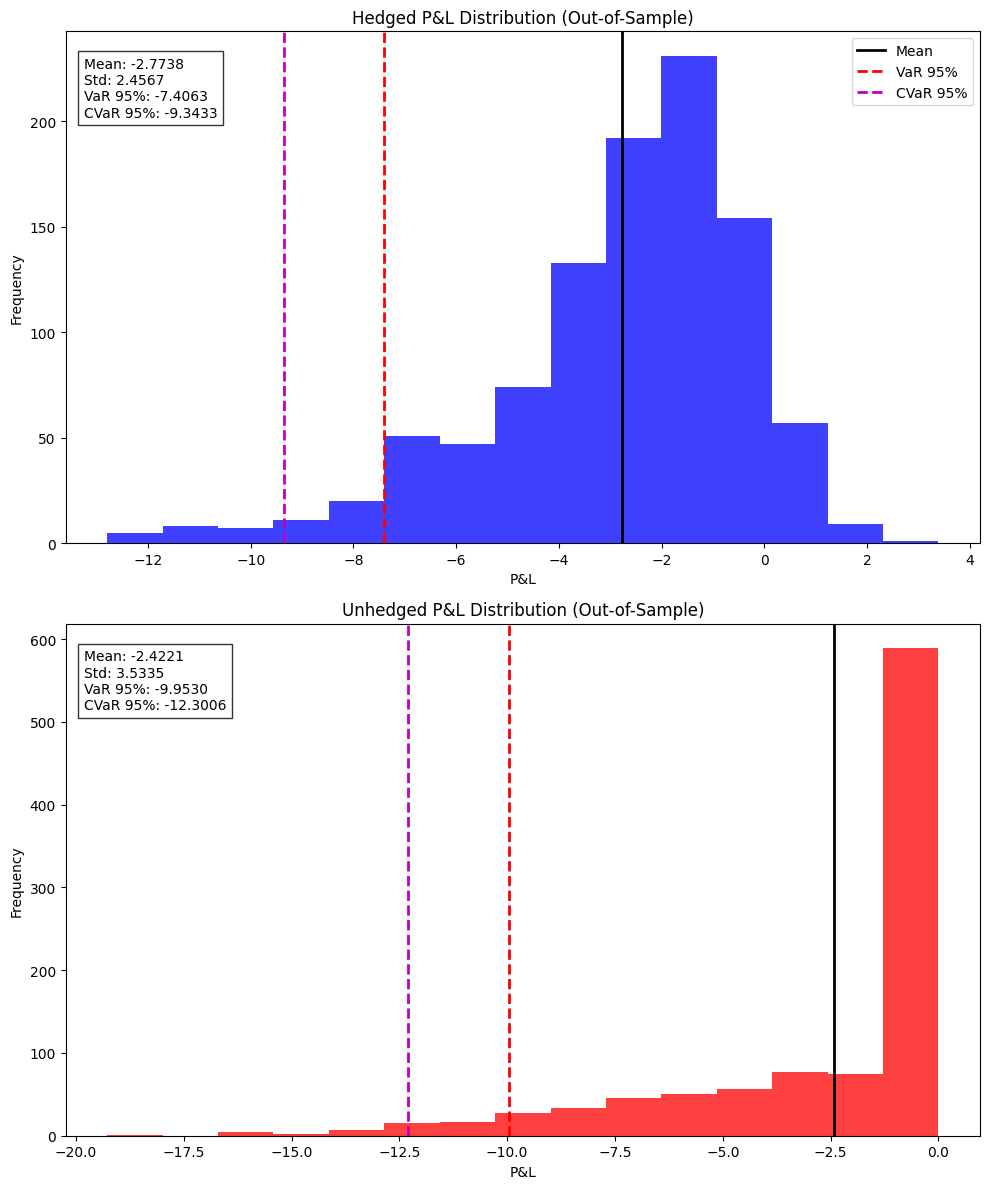

Risk Reduction from Hedging:
VaR Improvement: -2.5467
CVaR Improvement: -2.9573
Std Dev Reduction: 1.0768
---------------------------
this itteration the r_sig = 1, and r_const = 7
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.5264
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.6052
  Cash Balance: -59.4696
  Rebalancing Day: True
  Transaction Cost: 0.0269
  Reward: 0.1011
  Current PnL: -2.8650
  Moneyness (S/K): 0.9353
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.5264
  Option Payoff: 0.0000
  Portfolio Value: -2.8650
  Hedging Error: -2.8650
  Total Cost: 0.1788
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.00

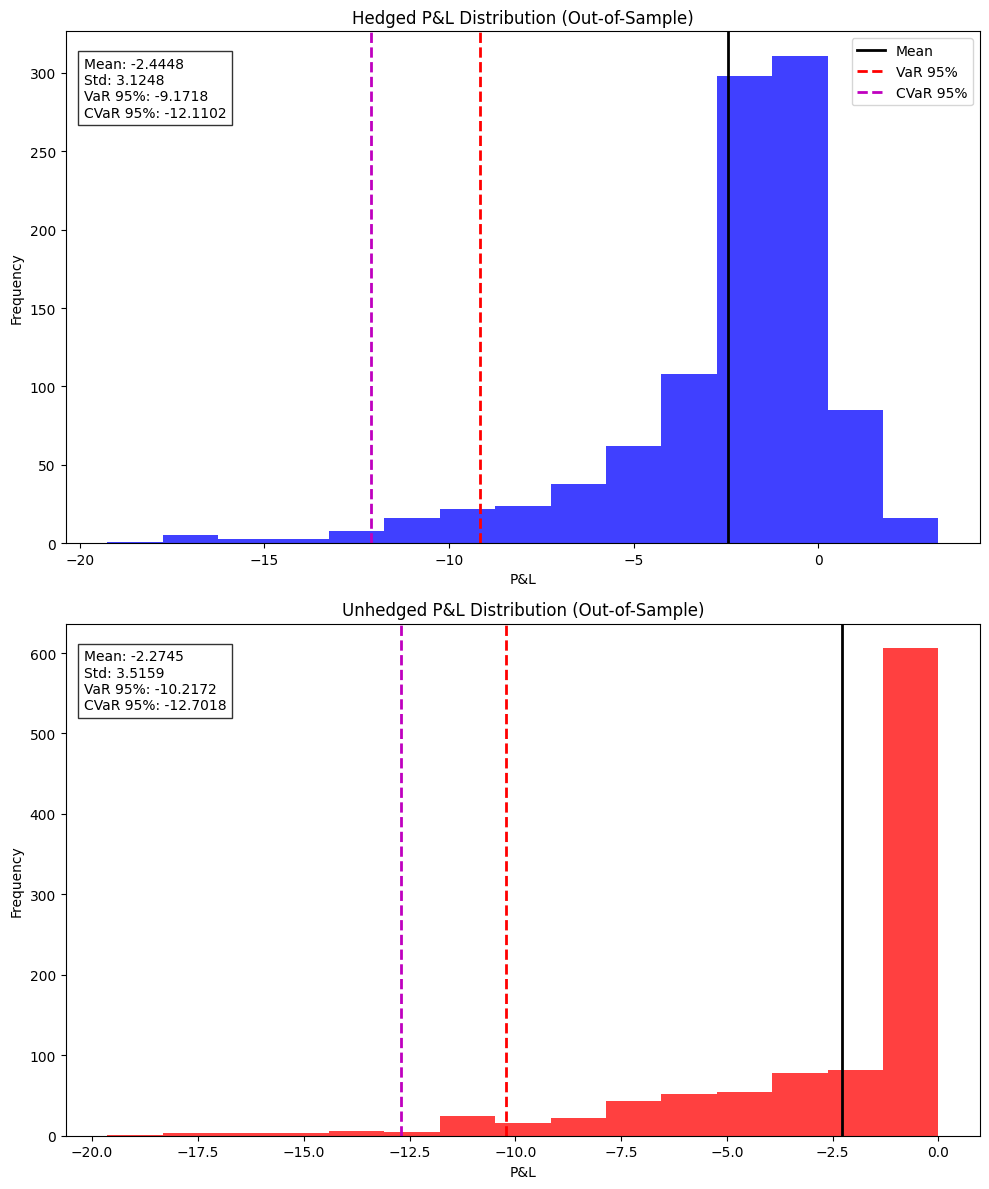

Risk Reduction from Hedging:
VaR Improvement: -1.0454
CVaR Improvement: -0.5916
Std Dev Reduction: 0.3911
---------------------------
this itteration the r_sig = 1, and r_const = 9
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 97.7912
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 1.0000
  Cash Balance: -100.1684
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 0.5920
  Current PnL: -2.3772
  Moneyness (S/K): 0.9779
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 97.7912
  Option Payoff: 0.0000
  Portfolio Value: -2.3772
  Hedging Error: -2.3772
  Total Cost: 0.1561
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0

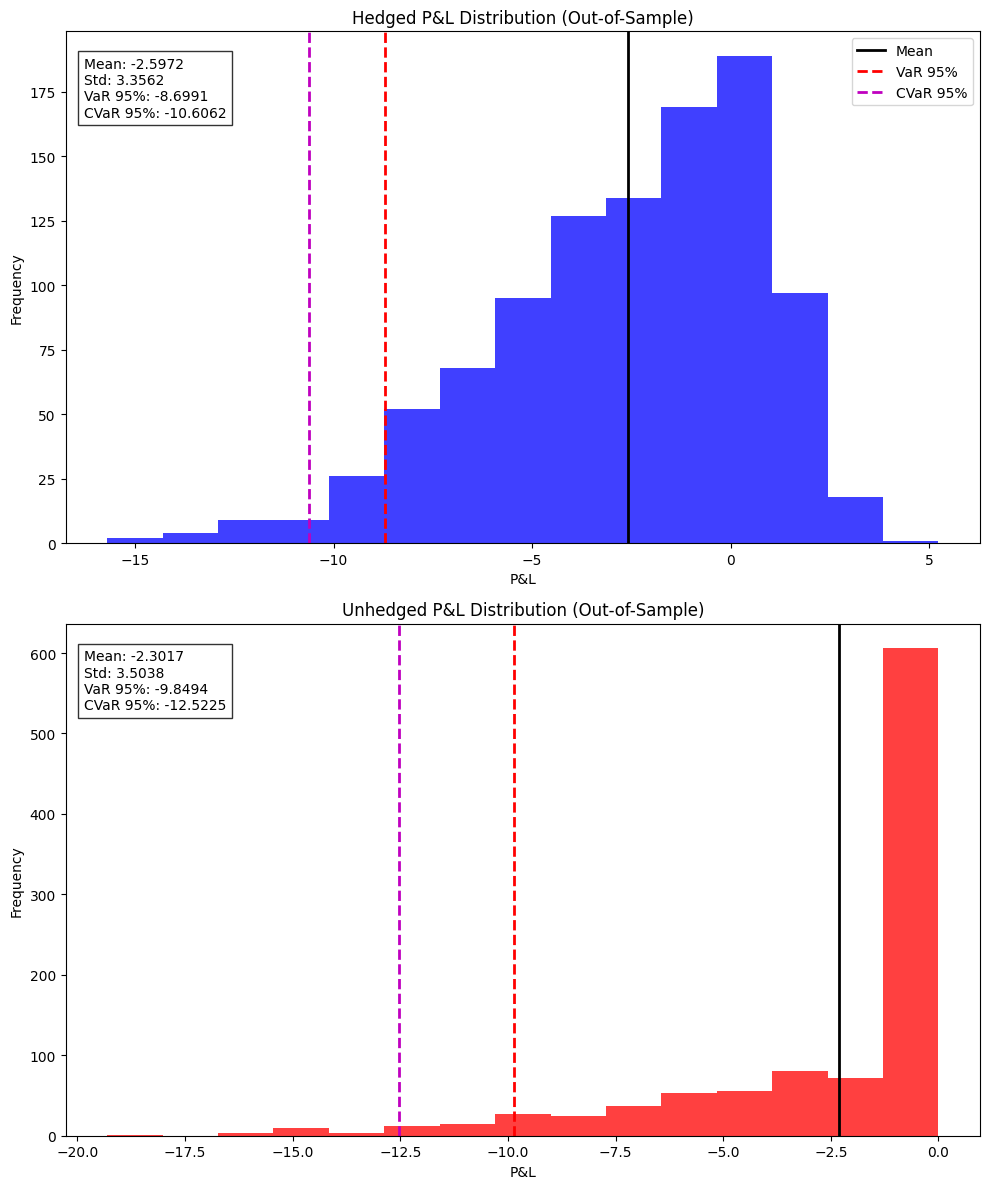

Risk Reduction from Hedging:
VaR Improvement: -1.1503
CVaR Improvement: -1.9163
Std Dev Reduction: 0.1476
---------------------------


In [11]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [3, 4, 5, 7, 9]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=40_000)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## timesteps [10_000, 20_000, 30_000]

this itteration the r_sig = 1, and r_const = 5
total_timesteps = 10000
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 101.8559
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -0.0024
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 1.1234
  Current PnL: -1.8559
  Moneyness (S/K): 1.0186
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 101.8559
  Option Payoff: 1.8559
  Portfolio Value: -0.0000
  Hedging Error: -1.8559
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancin

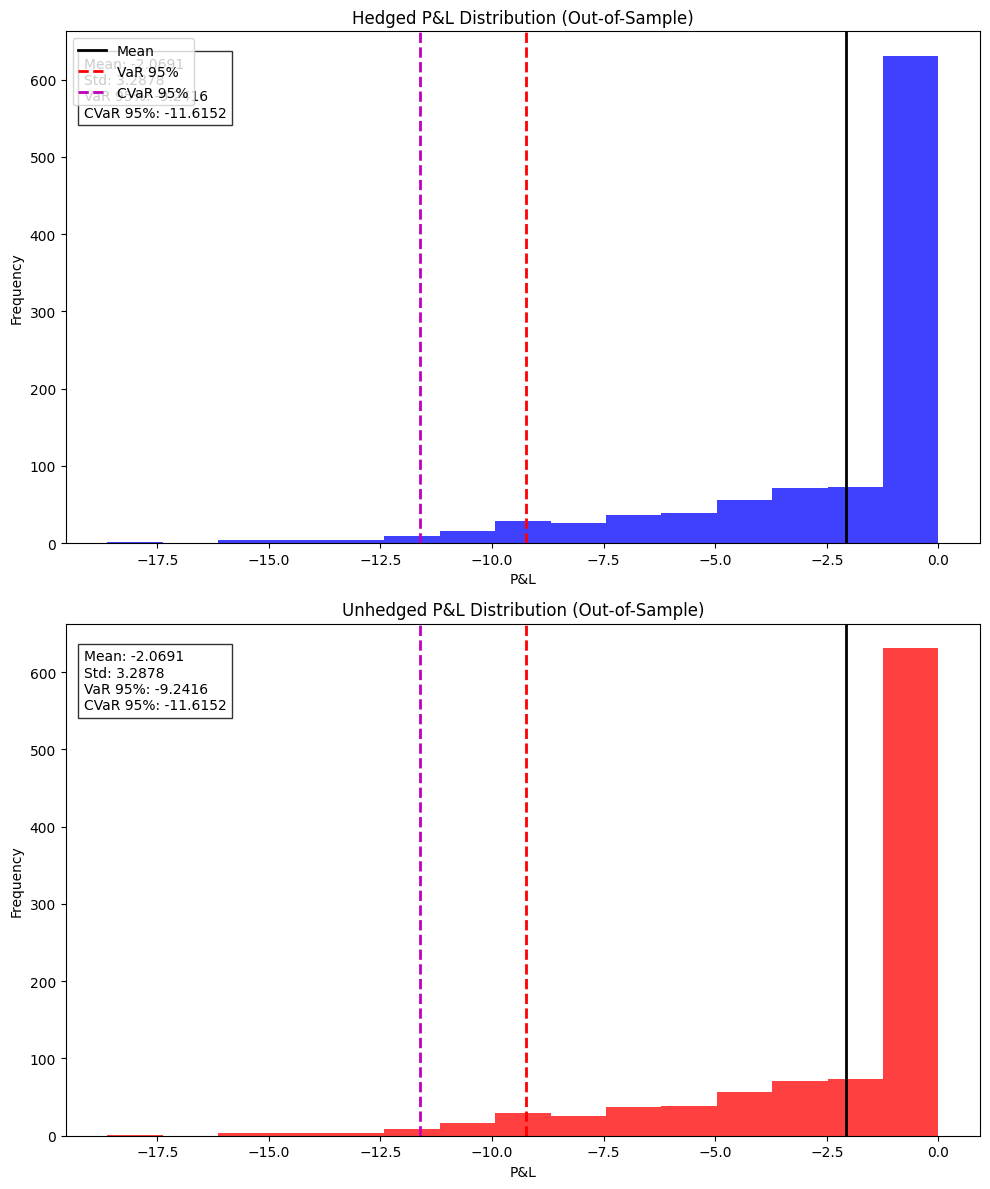

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------
this itteration the r_sig = 1, and r_const = 5
total_timesteps = 20000
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 98.3542
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0503
  Cash Balance: -4.3829
  Rebalancing Day: True
  Transaction Cost: 0.0045
  Reward: 4.3573
  Current PnL: 0.5681
  Moneyness (S/K): 0.9835
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 98.3542
  Option Payoff: 0.0000
  Portfolio Value: 0.5681
  Hedging Error: 0.5681
  Total Cost: 0.2527
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  S

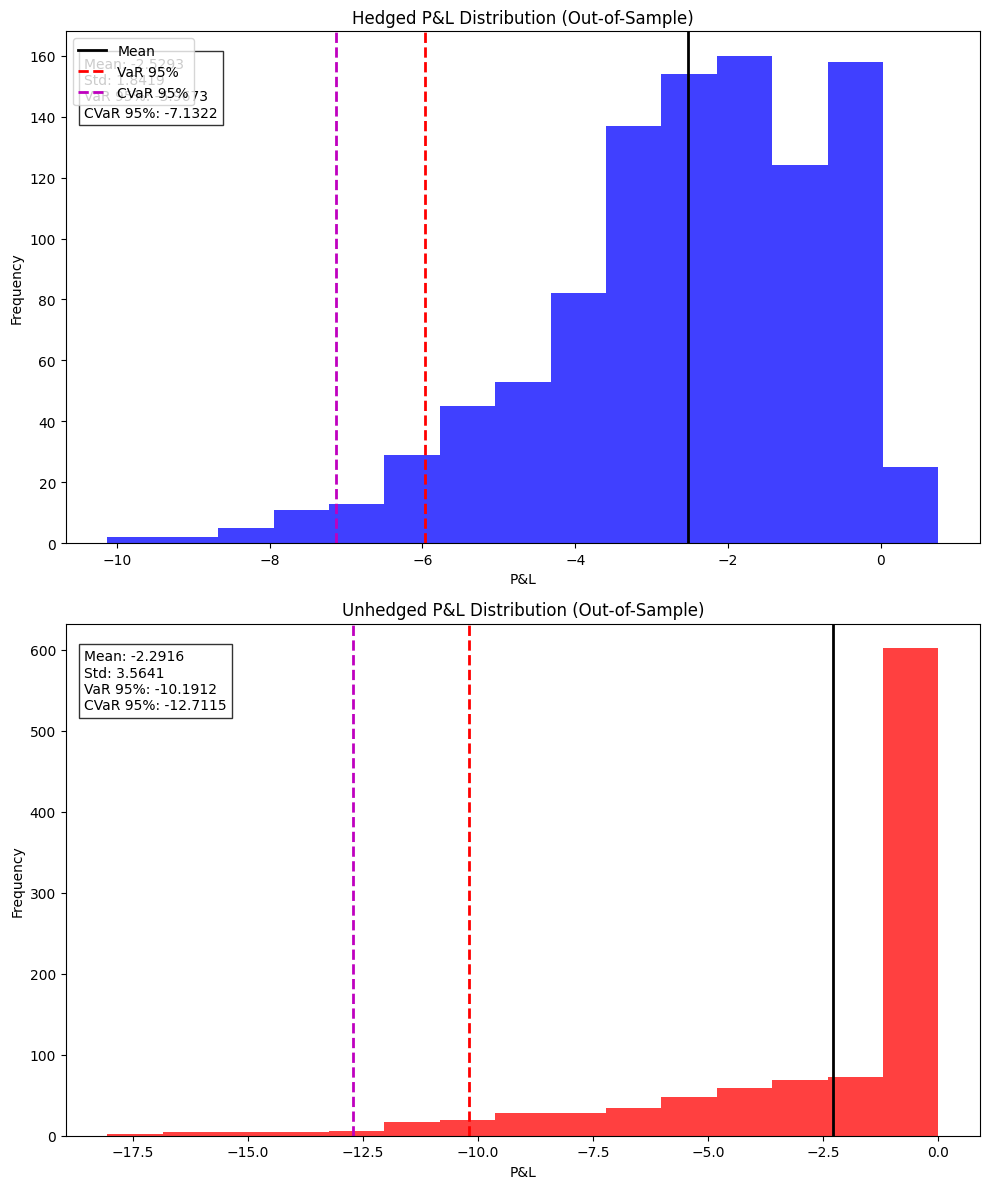

Risk Reduction from Hedging:
VaR Improvement: -4.2240
CVaR Improvement: -5.5793
Std Dev Reduction: 1.7222
---------------------------
this itteration the r_sig = 1, and r_const = 5
total_timesteps = 30000
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 96.9255
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.1091
  Current PnL: 0.0000
  Moneyness (S/K): 0.9693
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 96.9255
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  

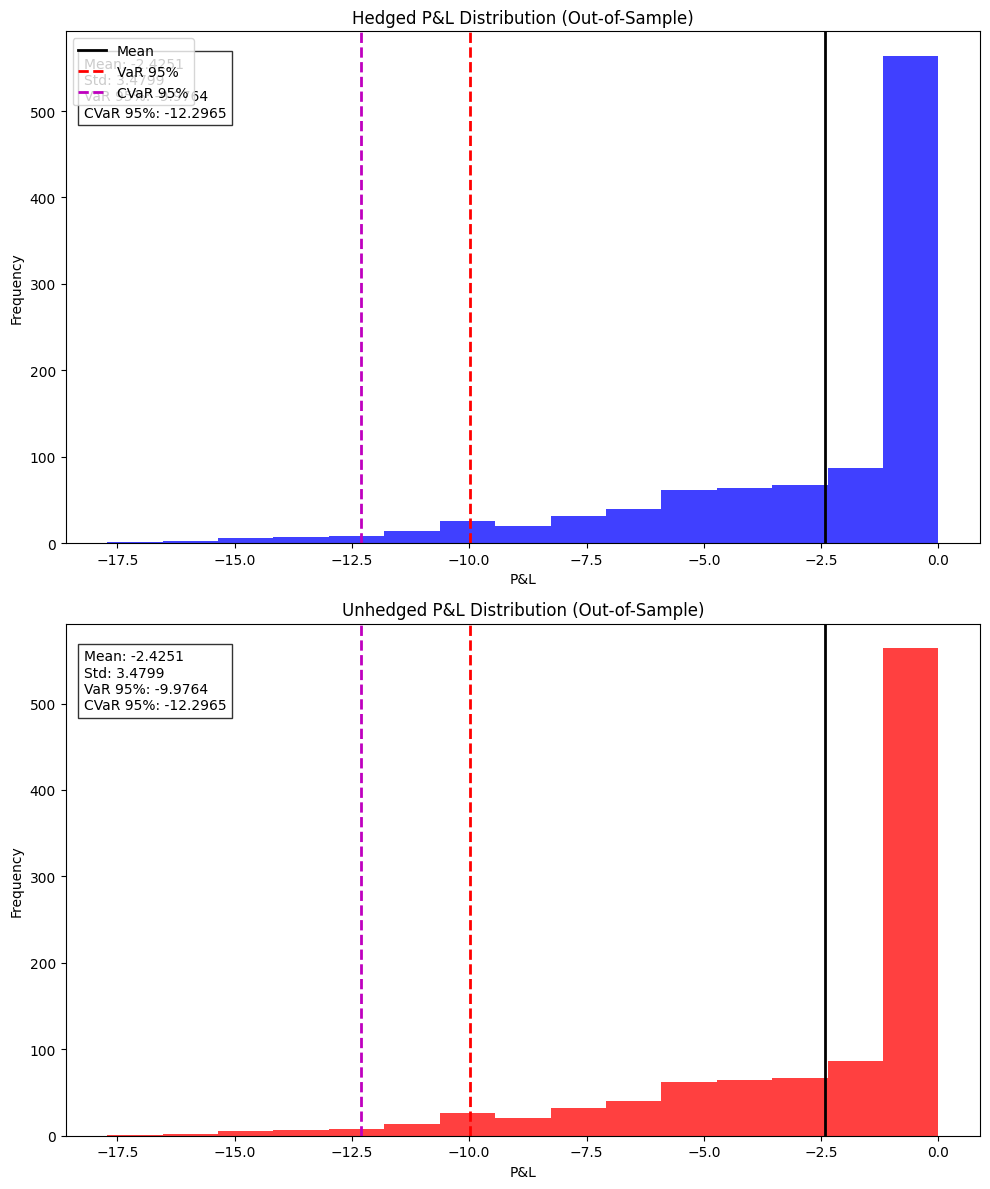

Risk Reduction from Hedging:
VaR Improvement: 0.0000
CVaR Improvement: 0.0000
Std Dev Reduction: 0.0000
---------------------------


In [13]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
r_const = 5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

STEPS = [10_000, 20_000, 30_000]

for total_steps in STEPS:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')
    print(f'total_timesteps = {total_steps}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=total_steps)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

## timesteps = 20k const 5, sigma 0.5

this itteration the r_sig = 0.5, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 93.1763
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 5.1002
  Current PnL: 0.0000
  Moneyness (S/K): 0.9318
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 93.1763
  Option Payoff: 0.0000
  Portfolio Value: 0.0000
  Hedging Error: 0.0000
  Total Cost: 0.0000
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400

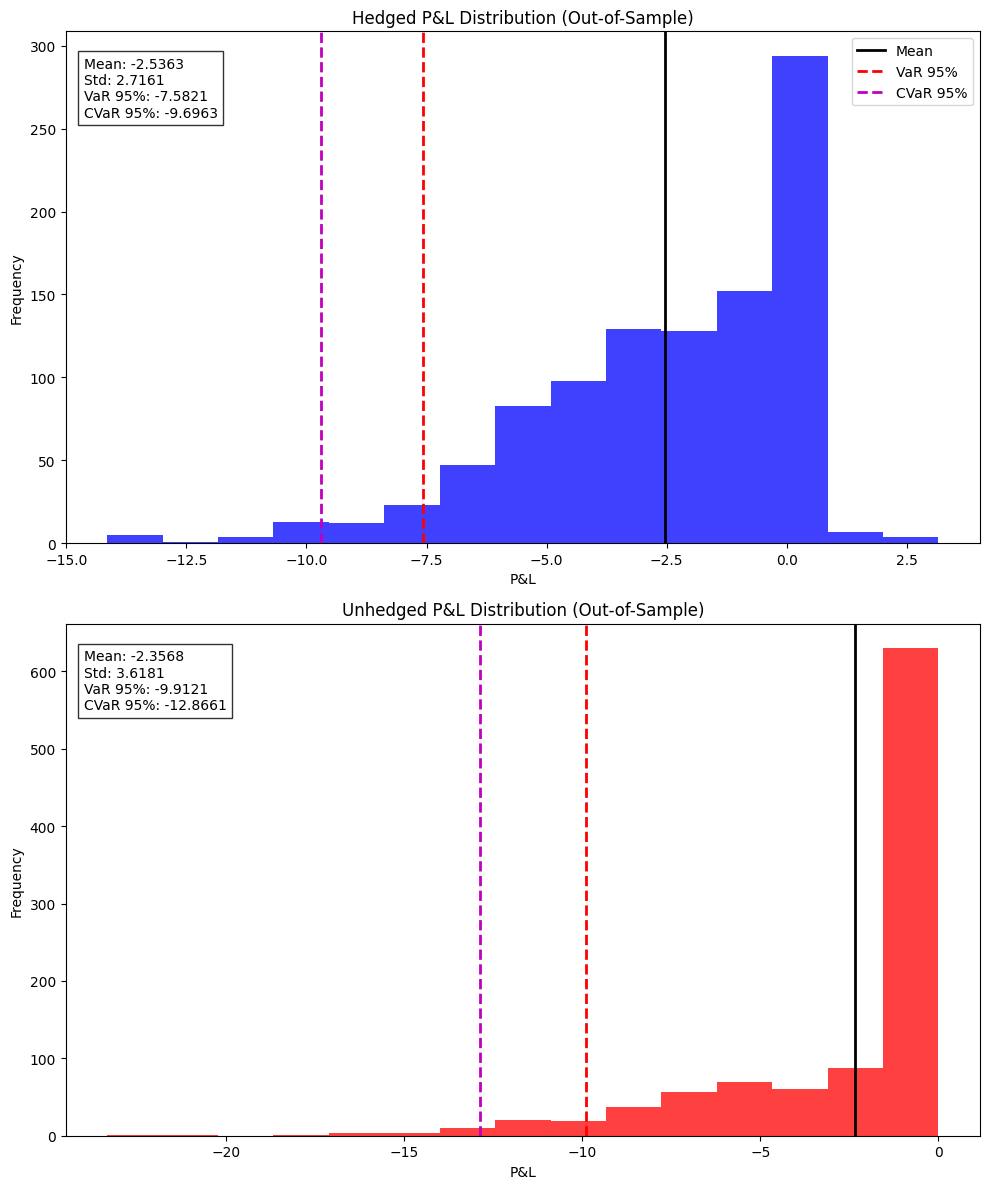

Risk Reduction from Hedging:
VaR Improvement: -2.3300
CVaR Improvement: -3.1698
Std Dev Reduction: 0.9020
---------------------------


In [14]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.5
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=20_000)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

this itteration the r_sig = 0.8, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 100.2071
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: 1.5291
  Rebalancing Day: True
  Transaction Cost: 0.1002
  Reward: 1.1919
  Current PnL: 1.3220
  Moneyness (S/K): 1.0021
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 100.2071
  Option Payoff: 0.2071
  Portfolio Value: 1.5291
  Hedging Error: 1.3220
  Total Cost: 0.2309
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:


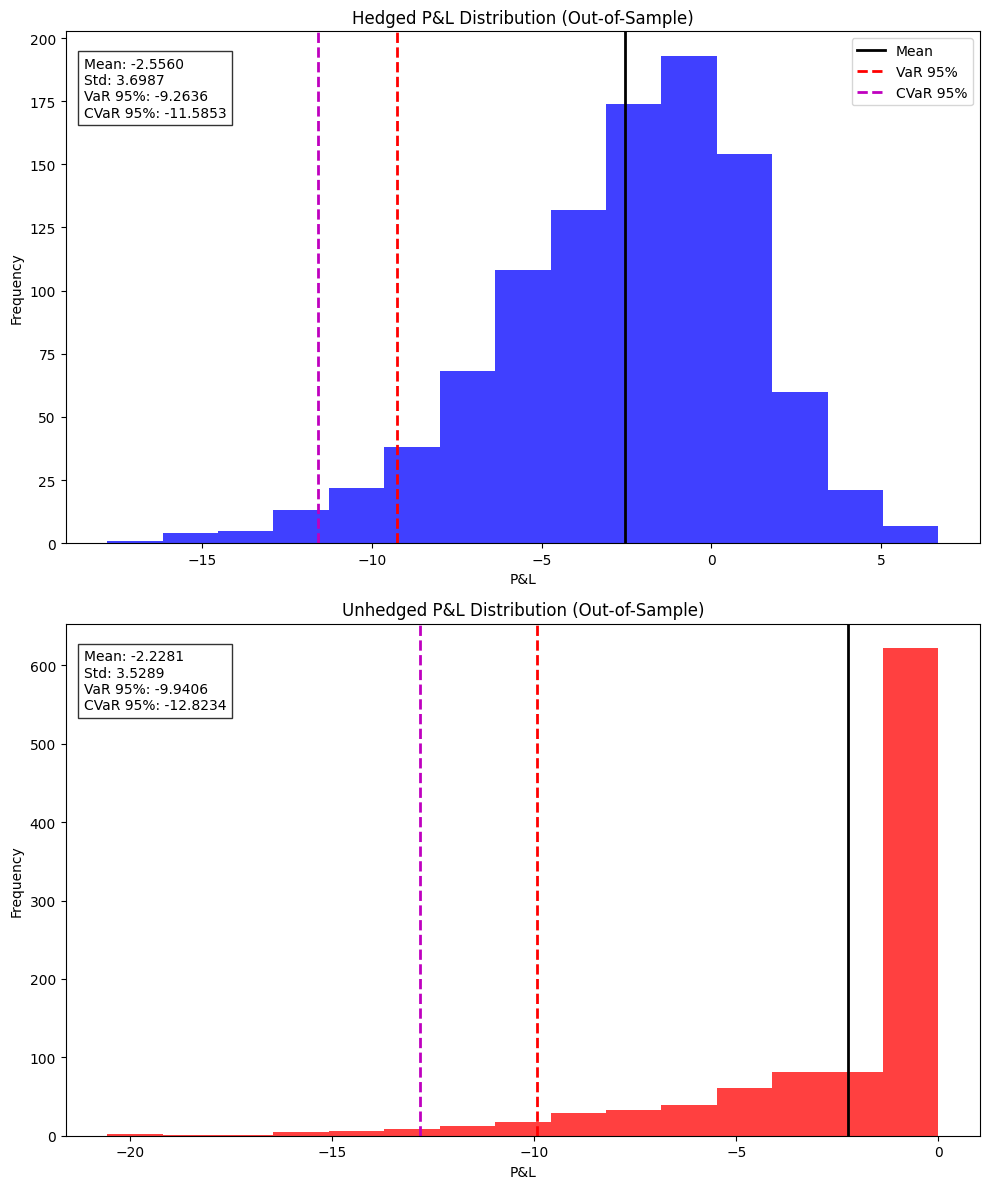

Risk Reduction from Hedging:
VaR Improvement: -0.6770
CVaR Improvement: -1.2381
Std Dev Reduction: -0.1698
---------------------------


In [15]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.8
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=20_000)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

this itteration the r_sig = 0.6, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 99.6211
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.0000
  Cash Balance: -0.7098
  Rebalancing Day: True
  Transaction Cost: 0.0000
  Reward: 2.5980
  Current PnL: -0.7098
  Moneyness (S/K): 0.9962
  Option Status: Out-of-the-money
Terminal State:
  Final Stock Price: 99.6211
  Option Payoff: 0.0000
  Portfolio Value: -0.7098
  Hedging Error: -0.7098
  Total Cost: 0.0399
  Total Rebalances: 22
Progress: 100/1000 paths evaluated
Progress: 200/1000 paths evaluated
Progress: 300/1000 paths evaluated
Progress: 400/1000 paths evaluated
Progress: 500/1000 paths evaluated
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399

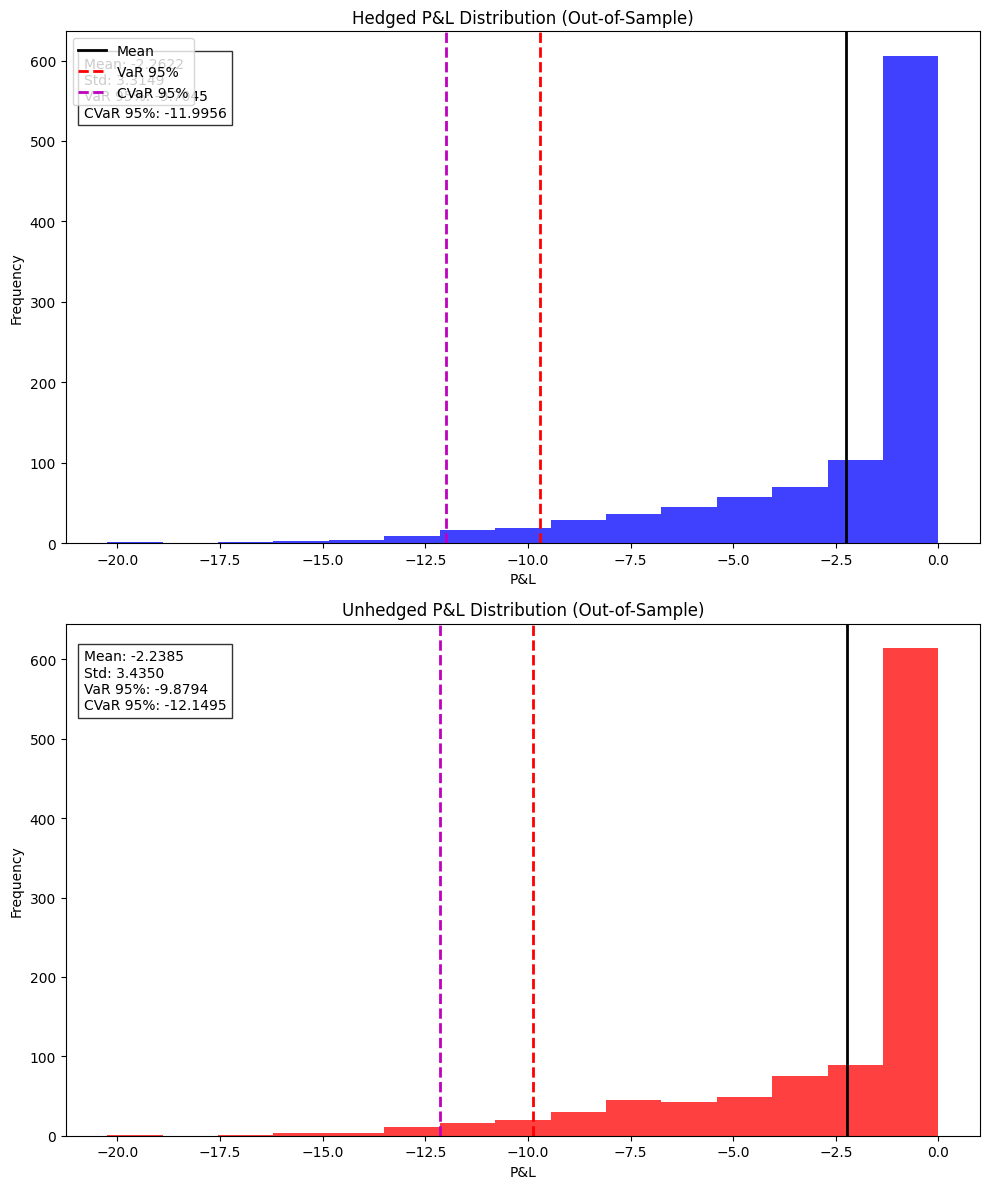

Risk Reduction from Hedging:
VaR Improvement: -0.1750
CVaR Improvement: -0.1539
Std Dev Reduction: 0.1201
---------------------------


In [16]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 0.6
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=20_000)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 1000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')

this itteration the r_sig = 1, and r_const = 5
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 106.1418
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.5472
  Cash Balance: -55.8689
  Rebalancing Day: True
  Transaction Cost: 0.0035
  Reward: -0.0845
  Current PnL: -3.9342
  Moneyness (S/K): 1.0614
  Option Status: In-the-money
Terminal State:
  Final Stock Price: 106.1418
  Option Payoff: 6.1418
  Portfolio Value: 2.2076
  Hedging Error: -3.9342
  Total Cost: 0.1531
  Total Rebalances: 22
Step 0/400:
  Stock Price: 100.0000
  Variance: 0.040000
  Time to Maturity: 0.0833
  Current Position: 0.0000
  Cash Balance: 0.0000
  Rebalancing Day: True
Step 399/400:
  Stock Price: 108.6254
  Variance: 0.040000
  Time to Maturity: 0.0000
  Current Position: 0.5564
  Cash Balance: -56.0498
  Rebalancing Day: True
  Transaction Cost: 0.00

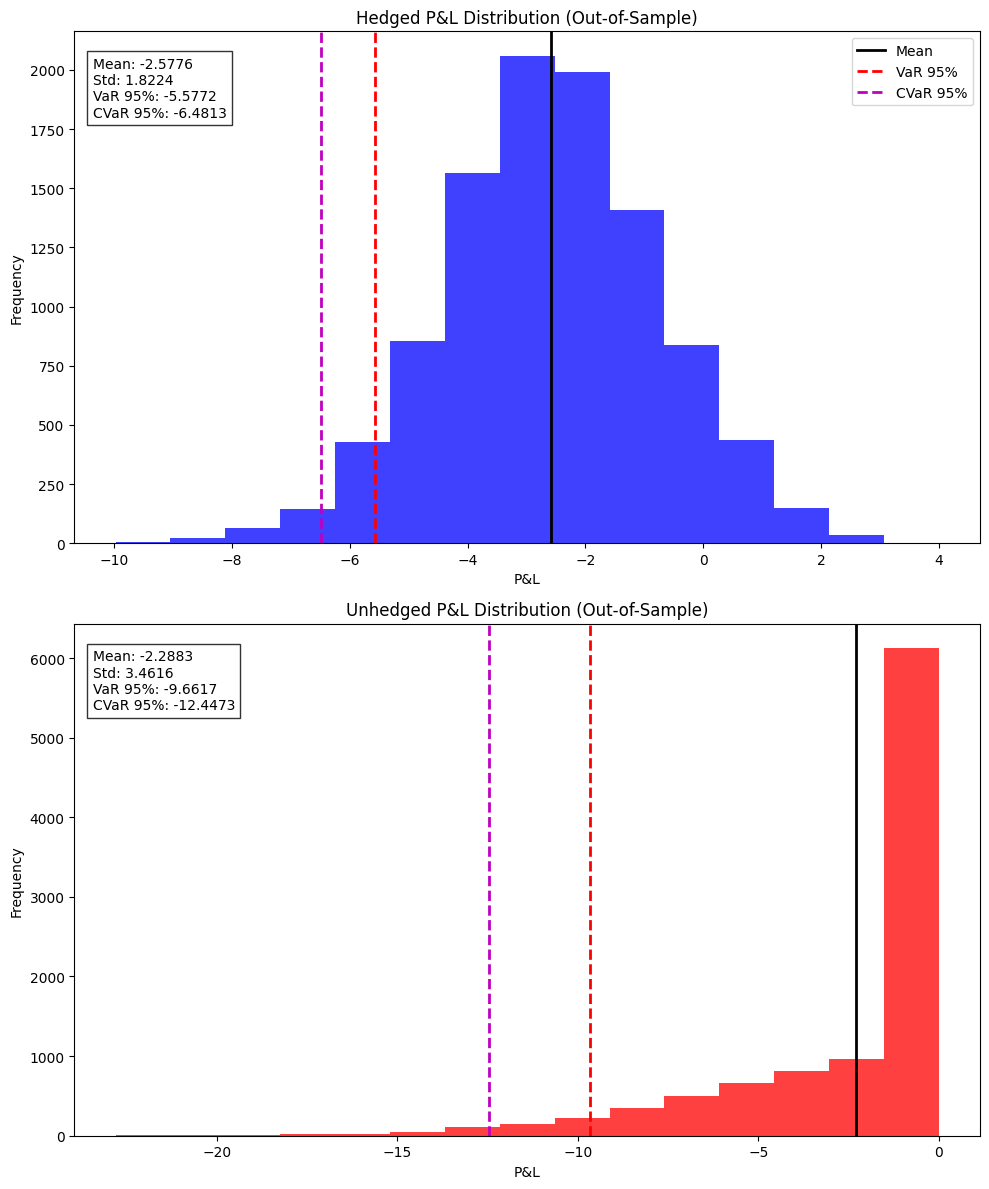

Risk Reduction from Hedging:
VaR Improvement: -4.0846
CVaR Improvement: -5.9660
Std Dev Reduction: 1.6393
---------------------------


In [17]:
heston_params={
    'S0': 100,
    'V0': 0.04,
    'rho': -0.7,
    'theta': 0.04,
    'sigma': 0.28,
    'kappa': 1,
    'r': 0.0,
    'q': 0.0
}

option_params={
    'T': 1/12,
    'K': 100,
    'r': 0.0,
}

action_lower = 0.0
action_upper = 1.0
option_premium = 0
reward_type = "zero_target_gaussian"
lambda_ = 1
r_sig = 1
n_steps = 400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r_consts = [5]

for r_const in r_consts:

    print(f'this itteration the r_sig = {r_sig}, and r_const = {r_const}')

    myenv = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    
    env_maker = lambda: myenv
    env = DummyVecEnv([env_maker])
    
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )
    
    model = TD3(
        policy="MlpPolicy",     
        env=env,
        action_noise=action_noise,
        verbose=0,
        device=device,
    )
    
    model.learn(total_timesteps=20_000)
    
    eval_env = BSMHedgingEnv_Daily(heston_params=heston_params,
                                   option_params=option_params,
                                   action_lower=action_lower,
                                   action_upper=action_upper,
                                   n_steps=n_steps,
                                   reward_type=reward_type,
                                   r_sig=r_sig,
                                   r_const=r_const,
                                   lambda_=lambda_)
    n_paths = 10000
    pnl_dist, unhedged_pnl = evaluate_policy(model, eval_env, option_premium=option_premium, n_paths=n_paths, render_every=500)
    
    plot_pnl_distributions(pnl_dist, unhedged_pnl)

    print('---------------------------')